Part A: Location Matching - Entity Resolution

1. Load in Data and perform Exploratory Data Analysis

In [830]:
#imports packages
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [831]:
# Load in data
raw_financials = pd.read_parquet(r"\original_data\raw_financials.parquet")
business_locations = pd.read_parquet(r"\original_data\business_locations.parquet")

In [832]:
#Check the dimentions of the data
print(raw_financials.shape)
print(business_locations.shape)

(4825372, 9)
(148871, 8)


In [833]:
raw_financials.head()

,id,name,address,city,state,postal_code,start_at,end_at,revenue
0,18a7003e-353e-4170-bcbe-043a17a81fce,Marco'S Pizza,3615 michael grove,LOUISVILLE,CO,69649,2022-02-01,2022-02-28,125464.83
1,17c5c7c4-e962-46db-8e3e-476ee68f150b,Marco'S Pizza,3615 michael grove,LOUISVILLE,CO,69649,2022-03-01,2022-03-31,121789.11
2,200a135b-8003-4144-90fe-4a756fa5484d,Marco'S Pizza,3615 michael grove,LOUISVILLE,CO,69649,2022-04-01,2022-04-30,119231.81
3,7a13f4d4-7c67-4a59-89c3-be1090dca3e2,Marco'S Pizza,3615 michael grove,LOUISVILLE,CO,69649,2022-05-01,2022-05-31,118129.99
4,415d4ba7-93e9-421c-b5e4-ab07a6ee1729,Marco'S Pizza,3615 michael grove,LOUISVILLE,CO,69649,2022-07-01,2022-07-31,112274.57


In [834]:
business_locations.head()

,id,business_entity_id,name,street_address,city,state,postal_code,area_sq_ft
0,5274da0a-9746-4e96-92c3-4b6054541f74,bdd640fb-0667-4ad1-9c80-317fa3b1799d,SUBWAY SANDWICHES,26773 Barrera Expressway,Waterford,CT,50173,1791
1,44784a1f-481d-4e53-a5a1-767bed1657e3,bdd640fb-0667-4ad1-9c80-317fa3b1799d,SUBWAY,7468 Moore Hill Apt. 098,Hawthorne,CA,08490,1198
2,b517801b-49c7-49f2-9813-da5d99a8b087,bdd640fb-0667-4ad1-9c80-317fa3b1799d,SUBWAY SANDWICHES,09788 Brian Pass Apt. 219,Ceres,CA,09408,5237
3,1688124d-0d52-49ea-a10b-18946869bb7d,bdd640fb-0667-4ad1-9c80-317fa3b1799d,SUBWAY SANDWICHES,1939 Christine Manor,Los Altos,CA,86664,1354
4,40345c64-4be4-4d75-a2ca-f7c19f7597e0,bdd640fb-0667-4ad1-9c80-317fa3b1799d,SUBWAY,3534 Anderson Rue Suite 751,Great Kills,NY,01721,7028


In [835]:
# Check data types and missing values
print("Data Types:\n", raw_financials.dtypes)
print("\nMissing Values:\n", raw_financials.isnull().sum())

Data Types:
 id                     object
name                   object
address                object
city                   object
state                  object
postal_code            object
start_at               object
end_at         datetime64[us]
revenue               float64
dtype: object

Missing Values:
 id             0
name           0
address        0
city           0
state          0
postal_code    0
start_at       0
end_at         0
revenue        0
dtype: int64


In [836]:
# Check data types and missing values
print("Data Types:\n", business_locations.dtypes)
print("\nMissing Values:\n", business_locations.isnull().sum())

Data Types:
 id                    object
business_entity_id    object
name                  object
street_address        object
city                  object
state                 object
postal_code           object
area_sq_ft             int64
dtype: object

Missing Values:
 id                    0
business_entity_id    0
name                  0
street_address        0
city                  0
state                 0
postal_code           0
area_sq_ft            0
dtype: int64


In [837]:
#does the id feild match? looks like no
matched_by_id = raw_financials.merge(business_locations, left_on="id", right_on = 'business_entity_id', how="inner")
print(len(matched_by_id), "rows matched by ID.")

0 rows matched by ID.


In [838]:
#how many unique values per column
print(business_locations.nunique())
print(raw_financials.nunique())

id                    148871
business_entity_id       100
name                     199
street_address        148870
city                    2849
state                     51
postal_code            77242
area_sq_ft              9500
dtype: int64
id             4825372
name               397
address         148870
city              5698
state               51
postal_code      96447
start_at            36
end_at              36
revenue        3262692
dtype: int64


In [839]:
#Curious about the address with two IDs given that there is one more unique id than address.  Maybe turnover of location?
business_locations['street_address'].value_counts()
# 023 Mark Prairie
business_locations.loc[business_locations['street_address'] == '023 Mark Prairie']
# we see that this is just coincidence of address and are in different states
#this is a good lesson that we cannot try to approx match accross different states or postal codes.

,id,business_entity_id,name,street_address,city,state,postal_code,area_sq_ft
71331,8f90d7de-d9a5-42bd-84b7-a298e3f4d20d,405cacec-8774-49a9-b7d2-1e02ff01cf99,ALDI INC OHIO,023 Mark Prairie,Galt,CA,53364,761
121916,338ad59d-b22a-4c79-8f32-ef0144dd6d42,b92da22b-21df-406f-8a0b-3c3336d8393a,PUBLIX SUPER MARKET AT BISCAYNE COMMONS,023 Mark Prairie,Cooper City,FL,53309,1350


2. Data Engineering.
-After seeing the unique values of each column, it looks like there are 148,871 different locations that I will need to match.
-To avoid unnecessary computational expense, my plan is to reduce the raw_financial data such that each location only has a single row before attempting any joins. (We may need to use an approximate match algorithm which can be slow for larger datasets)

In [840]:
# create a mapping table based on just the unique establishments from raw_financial
financial_unique_locs = raw_financials[["name","address", "city", "state","postal_code"]].drop_duplicates()
financial_unique_locs["source"] = "financials" 
financial_unique_locs.shape
# the fact that we are not getting 148871 rows means that we probably have an inconsistency in one of the above columns
# after going through the combos of address + col, I see that postal_code is the issue

(349278, 6)

In [841]:
#investigation into postal_code 

#All are correct lenth
raw_financials["postal_code"].str.len().value_counts()
#no unexpected characters
raw_financials[~raw_financials["postal_code"].str.match(r"^\d{5}(-\d{4})?$", na=False)]
#no extra spaces
raw_financials["postal_code"] = raw_financials["postal_code"].str.strip()

In [842]:
# could this be that over 2 years the postal codes have changed? This is unlikely.
# After looking up one of the postal codes I realize that they are generated for the purpose of this project so I can't verify which one is actually correct.
# It appears that the postal code with the vast majority of the entries (higher counts) align with the codes in business_locations so we will assume they are correct.
business_locations_check = business_locations.groupby(["name", "street_address", "city", "state", "postal_code"]).size().reset_index(name="count")
financial_unique_locs = raw_financials.groupby(["name", "address", "city", "state", "postal_code"]).size().reset_index(name="count")
financial_unique_locs.sort_values('address')

,name,address,city,state,postal_code,count
125283,HARDEE'S,000 ADRIAN RN. APT. 788,Rock Island,IL,74306,1
125282,HARDEE'S,000 ADRIAN RN. APT. 788,Rock Island,IL,74303,29
94280,Dunkin Donuts,000 ALVAREZ HEIGHTS,Salmon Creek,WA,59201,28
94283,Dunkin Donuts,000 ALVAREZ HEIGHTS,Salmon Creek,WA,59205,1
94282,Dunkin Donuts,000 ALVAREZ HEIGHTS,Salmon Creek,WA,59204,1
...,...,...,...,...,...,...
150736,Jackson Hewitt Tax Service,99998 GONZALEZ LKS.,Marion,OH,81503,31
162941,Kohl'S,99999 KAREN RAPIDS APT. 884,Woodstock,IL,41111,1
162942,Kohl'S,99999 KAREN RAPIDS APT. 884,Woodstock,IL,41113,1
162943,Kohl'S,99999 KAREN RAPIDS APT. 884,Woodstock,IL,41118,1


In [843]:
business_locations_check.sort_values('street_address')

,name,street_address,city,state,postal_code,count
54150,HARDEE'S,000 Adrian Run Apt. 788,Rock Island,IL,74303,1
39613,DUNKIN DONUTS,000 Alvarez Heights,Salmon Creek,WA,59201,1
96873,PAPA JOHN'S PIZZA,000 Ann Crossroad Apt. 555,Chicago Heights,IL,54179,1
92707,PANDA EXPRESS,000 Anthony Place,Arlington,WA,42461,1
112789,SEPHORA AT KOHL'S MADISON EAST,000 Anthony Tunnel Apt. 105,Valparaiso,IN,86620,1
...,...,...,...,...,...,...
2285,76,99992 Taylor Village Suite 307,Mechanicsville,VA,93692,1
18724,CHEVRON,99994 Allen Inlet,Clinton,UT,19137,1
95105,PANDA EXPRESS,99997 Jasmine Lake Suite 639,Beavercreek,OH,70962,1
63168,JACKSON HEWITT TAX SERVICE,99998 Gonzalez Lake,Marion,OH,81503,1


In [844]:
# keep rows with the more commonly occuring postal code 
# financial_unique_locs has expected number of rows now
financial_unique_locs = financial_unique_locs.sort_values(["name", "address", "city", "state", "count"], ascending=False).drop_duplicates(subset=["name", "address", "city", "state"], keep = 'first')
financial_unique_locs.shape

(148871, 6)

In [845]:
# Define a function that will convert string to lowercase, remove special characters, and remove leading and trailing whitespace
def clean_text(text):
    text = text.lower().strip() 
    text = re.sub(r"[^a-z0-9\s]", "", text)   
    return text

In [846]:
#feature engineer city
financial_unique_locs['city'] = financial_unique_locs['city'].apply(clean_text)
business_locations['city'] = business_locations['city'].apply(clean_text)

# check if there are any instances of city in financial_unique_locs but not in business_locations
financial_unique_locs.loc[~financial_unique_locs['city'].isin(business_locations['city'])]

,name,address,city,state,postal_code,count


In [847]:
#Make a new column called city_state_code that will be the concatenation of the city state and postal code
financial_unique_locs['city_state_code'] = financial_unique_locs['city'] + financial_unique_locs['state'] + financial_unique_locs['postal_code']
business_locations['city_state_code'] = business_locations['city'] + business_locations['state'] + business_locations['postal_code']

# This gives us total confidense that the combinations of city state and postal codes are one to one accross datasets
financial_unique_locs.loc[~financial_unique_locs['city_state_code'].isin(business_locations['city_state_code'])]
business_locations.loc[~business_locations['city_state_code'].isin(financial_unique_locs['city_state_code'])]

,id,business_entity_id,name,street_address,city,state,postal_code,area_sq_ft,city_state_code


In [848]:
# Feature engineer address
# after inspecting data more, it looks like there are too many different abbreviations to get an exact match on every address.
financial_unique_locs['address'] = financial_unique_locs['address'].apply(clean_text)
business_locations['street_address'] = business_locations['street_address'].apply(clean_text)

In [849]:
# Feature engineer name 
financial_unique_locs['name'] = financial_unique_locs['name'].apply(clean_text)
business_locations['name'] = business_locations['name'].apply(clean_text)
financial_unique_locs.loc[~financial_unique_locs['name'].isin(business_locations['name'])]

,name,address,city,state,postal_code,count,city_state_code


In [850]:
# All names match up but I can see that in business_locations there are multiple names for the same business_entity_id.
# I will make a new column called 'alt_names' that lists any alternative names reffering to the same business
# Group by business_entity_id and collect unique name variations
business_name_map = (
    business_locations.groupby("business_entity_id")["name"]
    .unique()  
    .apply(lambda x: ", ".join(sorted(x))) 
    .reset_index()
    .rename(columns={"name": "alt_names"}) 
)

business_locations = business_locations.merge(business_name_map, on="business_entity_id", how="left")
business_locations


,id,business_entity_id,name,street_address,city,state,postal_code,area_sq_ft,city_state_code,alt_names
0,5274da0a-9746-4e96-92c3-4b6054541f74,bdd640fb-0667-4ad1-9c80-317fa3b1799d,subway sandwiches,26773 barrera expressway,waterford,CT,50173,1791,waterfordCT50173,"subway, subway sandwiches"
1,44784a1f-481d-4e53-a5a1-767bed1657e3,bdd640fb-0667-4ad1-9c80-317fa3b1799d,subway,7468 moore hill apt 098,hawthorne,CA,08490,1198,hawthorneCA08490,"subway, subway sandwiches"
2,b517801b-49c7-49f2-9813-da5d99a8b087,bdd640fb-0667-4ad1-9c80-317fa3b1799d,subway sandwiches,09788 brian pass apt 219,ceres,CA,09408,5237,ceresCA09408,"subway, subway sandwiches"
3,1688124d-0d52-49ea-a10b-18946869bb7d,bdd640fb-0667-4ad1-9c80-317fa3b1799d,subway sandwiches,1939 christine manor,los altos,CA,86664,1354,los altosCA86664,"subway, subway sandwiches"
4,40345c64-4be4-4d75-a2ca-f7c19f7597e0,bdd640fb-0667-4ad1-9c80-317fa3b1799d,subway,3534 anderson rue suite 751,great kills,NY,01721,7028,great killsNY01721,"subway, subway sandwiches"
...,...,...,...,...,...,...,...,...,...,...
148866,5ba3b1a0-b645-459d-9481-c9ada2ff5503,03c72ba8-d605-4770-8a63-f881ffd0f9d5,hobby lobby,860 stephenson route suite 132,leominster,MA,63559,7525,leominsterMA63559,"hobby lobby, hobby lobby stores inc"
148867,bea4ed1a-bd68-46bb-914c-14b484411bae,03c72ba8-d605-4770-8a63-f881ffd0f9d5,hobby lobby stores inc,6029 crystal manors,north tustin,CA,68486,2052,north tustinCA68486,"hobby lobby, hobby lobby stores inc"
148868,7978dce7-545c-445a-b62a-c39656b36886,03c72ba8-d605-4770-8a63-f881ffd0f9d5,hobby lobby,526 stone lodge,van nuys,CA,80200,1207,van nuysCA80200,"hobby lobby, hobby lobby stores inc"
148869,c331740b-5445-42dd-aae0-fbdd8f899535,03c72ba8-d605-4770-8a63-f881ffd0f9d5,hobby lobby,444 erin divide,goldsboro,NC,53347,3045,goldsboroNC53347,"hobby lobby, hobby lobby stores inc"


3. Join the data with the following plan:
- step 1: join on the combination of city_state_code and address and remove matches from the data.
- step 2: join on the combination of city_state_code and name.
    - step 2.1: If there is no name match we can leverage the alternative names column
    - step 2.2: If there are multiple matches (indicating that a business has multiple locations in the same city and postal code) we can use an approximate match algorithm on the address column and take the higher similarity score

In [851]:
# step 1: Merge on exact city, state, postal_code, and address
exact_address_matches = financial_unique_locs.merge(business_locations, 
left_on = ["city_state_code", "address"], right_on = ["city_state_code", "street_address"], how = "inner", suffixes=("_fin", "_bus"))

joined_df = exact_address_matches.copy()

# Remove matched rows from raw_financials
financial_unique_locs = financial_unique_locs[~financial_unique_locs.set_index(["city_state_code", "address"]).index.isin(exact_address_matches.set_index(["city_state_code", "address"]).index)]
# Remove matched rows from business_locations
business_locations = business_locations[~business_locations.set_index(["city_state_code", "street_address"]).index.isin(exact_address_matches.set_index(["city_state_code", "street_address"]).index)]

print(f"Rows remaining in raw_financials: {len(business_locations)}")
print(f"Rows remaining in business_locations: {len(business_locations)}")
print(f"Rows moved to joined_df: {len(joined_df)}")

Rows remaining in raw_financials: 48662
Rows remaining in business_locations: 48662
Rows moved to joined_df: 100209


In [852]:
# before step 2: joining on name, check for instances of the same business name coming up more than once within a city_state_code
# we observe there are none
duplicate_check = financial_unique_locs.groupby(["name", "city_state_code"]).size().reset_index(name="count")
duplicates = duplicate_check[duplicate_check["count"] > 1]
print(duplicates)

Empty DataFrame
Columns: [name, city_state_code, count]
Index: []


In [853]:
# step 2: Merge on exact city, state, postal_code, and name
exact_name_matches = financial_unique_locs.merge(business_locations, on = ["city_state_code", "name"], how = "inner", suffixes=("_fin", "_bus"))

# Remove matched rows from raw_financials
financial_unique_locs = financial_unique_locs[~financial_unique_locs.set_index(["city_state_code", "name"]).index.isin(exact_name_matches.set_index(["city_state_code", "name"]).index)]
# Remove matched rows from business_locations
business_locations = business_locations[~business_locations.set_index(["city_state_code", "name"]).index.isin(exact_name_matches.set_index(["city_state_code", "name"]).index)]

#rename the name attribute to be consistent
joined_df.rename(columns={'name_fin':'name'},inplace=True)

joined_df = pd.concat([joined_df,exact_name_matches], ignore_index=True)

print(f"Rows remaining in raw_financials: {len(business_locations)}")
print(f"Rows remaining in business_locations: {len(business_locations)}")
print(f"Rows moved to joined_df: {len(joined_df)}")

Rows remaining in raw_financials: 0
Rows remaining in business_locations: 0
Rows moved to joined_df: 148871


All rows have now been joined using only steps 1 and 2. 
- The next step of using similarity score to ensure the join was correct is not essential but it was a nice way to check my work
- The final step will be a left join on my original raw_financial dataframe and joined_df

In [854]:
# use approx match to ensure that none of the rows joined by name have different addresses
from rapidfuzz import fuzz

# Compute similarity score
joined_df["similarity"] = joined_df.apply(lambda x: fuzz.token_set_ratio(x["address"], x["street_address"]) / 100, axis=1)

#even the few low scores match properly
joined_df.loc[:,['address','street_address','similarity']].sort_values('similarity')

,address,street_address,similarity
128230,6489 ch ctrs,6489 church centers,0.580645
123882,235 w wk,235 west walk,0.666667
144731,52791 prker pl,52791 parker place,0.687500
132286,7042 prks pkwy,7042 parks parkway,0.687500
125574,253 w mtn,253 west mountain,0.692308
...,...,...,...
49624,0335 mcknight spring,0335 mcknight spring,1.000000
49625,0292 jesus rapid,0292 jesus rapid,1.000000
49626,02307 nicole glen suite 644,02307 nicole glen suite 644,1.000000
49646,924 payne via apt 192,924 payne via apt 192,1.000000


In [855]:
# join on raw_financials and joined_df using address and name

#preprocess address and name the same way it appears in join_df
raw_financials['address'] = raw_financials['address'].apply(clean_text)
raw_financials['name'] = raw_financials['name'].apply(clean_text)


# left join
financial = raw_financials.merge(joined_df, how = 'left', on = ['address','name'])

# take the columns we need (including the correct version of postal code)
financial = financial.loc[:,['id_x','name','address','city','state','postal_code_bus','start_at','end_at','revenue','business_entity_id','street_address','area_sq_ft','alt_names']]
financial.rename(columns={'id_x':'id','postal_code_bus':'postal_code'},inplace=True)


Part B: Revenue Analysis - Financial Adjustment

 https://capitaloneshopping.com/research/cash-vs-credit-card-spending-statistics/ We will use this breakdown from Capitalone of in-store retail sales in the U.S. 2023 as our jumping off point
 - 41% Credit card
 - 28% Debit card
 - 15% Digital wallet
 - 12% Cash
 - 3% prepaid card
 - 1% Consumer financing

After getting bogged down with what the digital wallet portion comprises of, I decided for this excersize to make the assumption that all digital wallet transactions are already captured in our data.  In my understanding, digital wallet is going to be credit or debit cards tied to a digital account like Apple Pay.  I would guess that this data would get recorded the same regardless of if a phone or card was tapped.  I am not very familiar with how how we got this data and I understand that this is a major assumption that is likely at least partially incorrect.  Nevertheless it will not impact my model's ability to predict cash and consumer financing which are the categories I am confident are not in our current data.

When forcasting the missing 13% of our transaction data, I will refer to it and treat it like its all cash for simplicity purposes.



Other key sources for data and facts used to design my model: 

https://scorecard.prosperitynow.org/reports#report-data-table - where my outside data came from
https://dualpayments.com/statistics/cash-vs-credit-card-spending-statistics/ - average cash and credit card purchase size
https://www.frbservices.org/binaries/content/assets/crsocms/news/research/2024-diary-of-consumer-payment-choice.pdf - % of cash transactions accross our three groups 


My model uses two factors to predicting cash usage. 
1. The rate of unbanked and underbanked individuals in each city
2. The square footage of each store

Estimating the percent of cash revenue in a city based on the population of unbanked, underbanked, and fully banked households

After researching the best predictors of cash transactions, I found unbanked and underbanked rates to be highly effective as well as logical as they seem to capture more than just the poverty of an area but also the cultural reliance on banking.  Households without bank accounts obviously will use cash at a much higher rate than those with bank accounts. 

My first task is to derive the percentage of cash spent from each of our three defined groups. I unfortunately wasn't able to get this exact data but did find the percentage of their transactions that are in cash from the FRB. Using statistics about the average size of a cash transaction vs a card transaction, as well as the total U.S. percent of in-store sales in cash I will make educated estimates about each groups cash spend.

I will use national statistics to solve for missing variables:
- total percent of in-store sales in cash - 12%
- Unbanked households are 4.5% of the population and 66% of all their transactions are in cash
- Underbanked households are 15.2% of the population and 35% of all their transactions are in cash 
- Fully banked households are 84.8% of the population and 17% of their transactions are in cash
- The average cash transaction is $22 while the average card transaction is $112. As a result we will scale the percent of transactions by 22/112 or .196 to bridge the gap between percent of transactions in cash and percent of sales in cash

.12 = (Scaler)(.196)[.045*.66 + .152*.35 + .848*.17]

Scaler = 2.696

Scaler*.196 = .528  This value will be applied to each of the groups percent of transactions in cash to estimate the groups percent of spend in cash

Unbanked: .35
Underbanked: .18
Fully banked: .09

A region's estimated percent of sales in cash can be solved with the following:

regional_estimation_of_payment_in_cash = percent_unbanked*.35 + percent_underbanked*.18 + fully_banked*.09  


In [856]:
joined_df.columns

Index(['name', 'address', 'city_fin', 'state_fin', 'postal_code_fin', 'count',
       'city_state_code', 'id', 'business_entity_id', 'name_bus',
       'street_address', 'city_bus', 'state_bus', 'postal_code_bus',
       'area_sq_ft', 'alt_names', 'similarity'],
      dtype='object')

In [857]:
locations = joined_df.loc[:,['name', 'address', 'city_fin', 'state_fin', 'postal_code_fin',
        'id', 'business_entity_id','area_sq_ft', 'alt_names']]
locations.columns = ['name', 'address', 'city', 'state', 'postal_code',
        'id', 'business_entity_id','area_sq_ft', 'alt_names']

In [858]:
#Bring in unbanked_data and join/clean up
unbanked_state = pd.read_csv(r'external_data\unbanked_by_state.csv')
unbanked_by_city_1 = pd.read_csv(r'\external_data\unbanked_by_city_1.csv')
unbanked_by_city_2 = pd.read_csv(r'\external_data\unbanked_by_city_2.csv')
unbanked_by_city_3 = pd.read_csv(r'\external_data\unbanked_by_city_3.csv')
unbanked_by_city_4 = pd.read_csv(r'\external_data\unbanked_by_city_4.csv')


unbanked_by_city = pd.concat([unbanked_by_city_1,unbanked_by_city_2,unbanked_by_city_3,unbanked_by_city_4], ignore_index = True)
unbanked_by_city.columns = ['city','poverty_rate','unbanked','underbanked']
unbanked_state.columns = ['state','poverty_rate','unbanked','underbanked']

cols = ['poverty_rate', 'unbanked', 'underbanked']
# First, convert columns to float64 so that subsequent assignments are compatible.
unbanked_by_city[cols] = unbanked_by_city[cols].astype('float64')
unbanked_state[cols] = unbanked_state[cols].astype('float64')

# Now divide by 100 to convert to decimals.
unbanked_by_city[cols] /= 100
unbanked_state[cols] /= 100

# Split 'city' column into 'city' and 'state' and clean city to be joined.
unbanked_by_city[['city', 'state']] = unbanked_by_city["city"].str.rsplit(", ", n=1, expand=True)
unbanked_by_city['city'] = unbanked_by_city['city'].apply(clean_text)
unbanked_by_city.drop_duplicates(inplace=True)

unbanked_by_city.head()

,city,poverty_rate,unbanked,underbanked,state
0,maconbibb county,0.252,0.14,0.20,GA
1,hartford,0.284,0.12,0.24,CT
2,bridgeport,0.232,0.10,0.23,CT
3,east los angeles,0.179,0.10,0.27,CA
4,augusta,0.221,0.09,0.19,GA


In [859]:
# Dictionary mapping full state names to abbreviations
state_abbrev_map = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA",
    "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "Florida": "FL", "Georgia": "GA",
    "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA",
    "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO",
    "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ",
    "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND",
    "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI",
    "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT",
    "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV",
    "Wisconsin": "WI", "Wyoming": "WY", "District of Columbia" : "DC"

}

# Apply the mapping to the 'state' column
unbanked_state["state"] = unbanked_state["state"].map(state_abbrev_map)

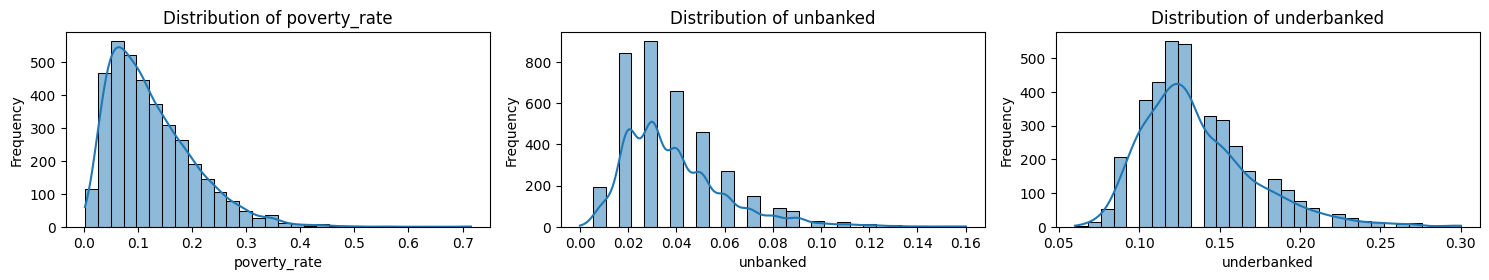

In [860]:
#get visualizations of new variables 
variables = ["poverty_rate", "unbanked", "underbanked"]
plt.figure(figsize=(15, 5))
for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)
    sns.histplot(unbanked_by_city[var], kde=True, bins=30)
    plt.title(f"Distribution of {var}")
    plt.xlabel(var)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

The plan for joining our unbanked and underbanked data is to join by city.  Since our data consists of every city over 10,000 population we will first join on city and if the city is not found then we will use the state data.

In [861]:
# Merge on city and state 
df_merged = locations.merge(unbanked_by_city, on=["city", "state"], how="left", suffixes=("", "_city"))
df_merged.drop_duplicates(subset = ['address','name','state'], inplace = True)

# Merge state-level data (Only fill missing city matches)
df_merged = df_merged.merge(unbanked_state, on="state", how="left", suffixes=("", "_state"))

# Fill missing city-level values with state-level data
for col in unbanked_by_city.columns.difference(["city", "state"]):  # Avoid overwriting city/state
    df_merged[col] = df_merged[col].fillna(df_merged[f"{col}_state"])

# Drop temporary state-level columns
df_merged.drop(columns=[col + "_state" for col in unbanked_by_city.columns.difference(["city", "state"])], inplace=True)



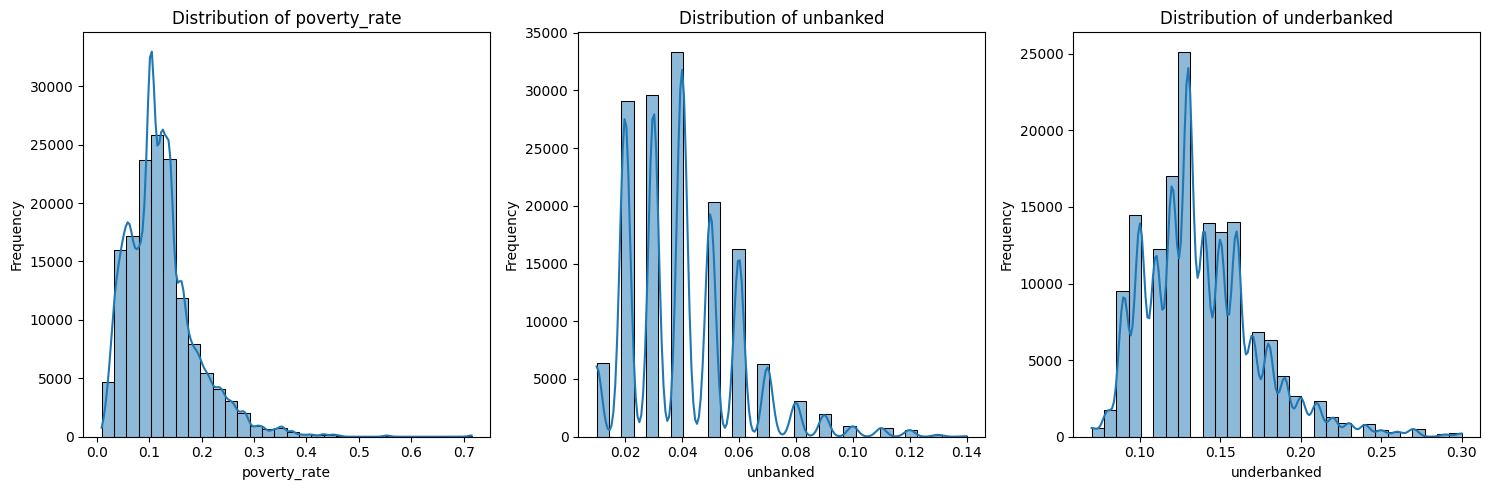

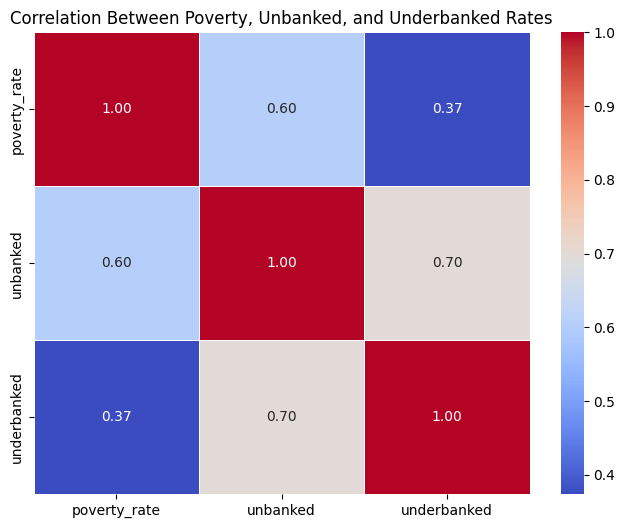

In [862]:
#Visualize the distributions and correlations

variables = ["poverty_rate", "unbanked", "underbanked"]
plt.figure(figsize=(15, 5))
for i, var in enumerate(variables, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df_merged[var], kde=True, bins=30)
    plt.title(f"Distribution of {var}")
    plt.xlabel(var)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = df_merged[variables].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Poverty, Unbanked, and Underbanked Rates")
plt.show()


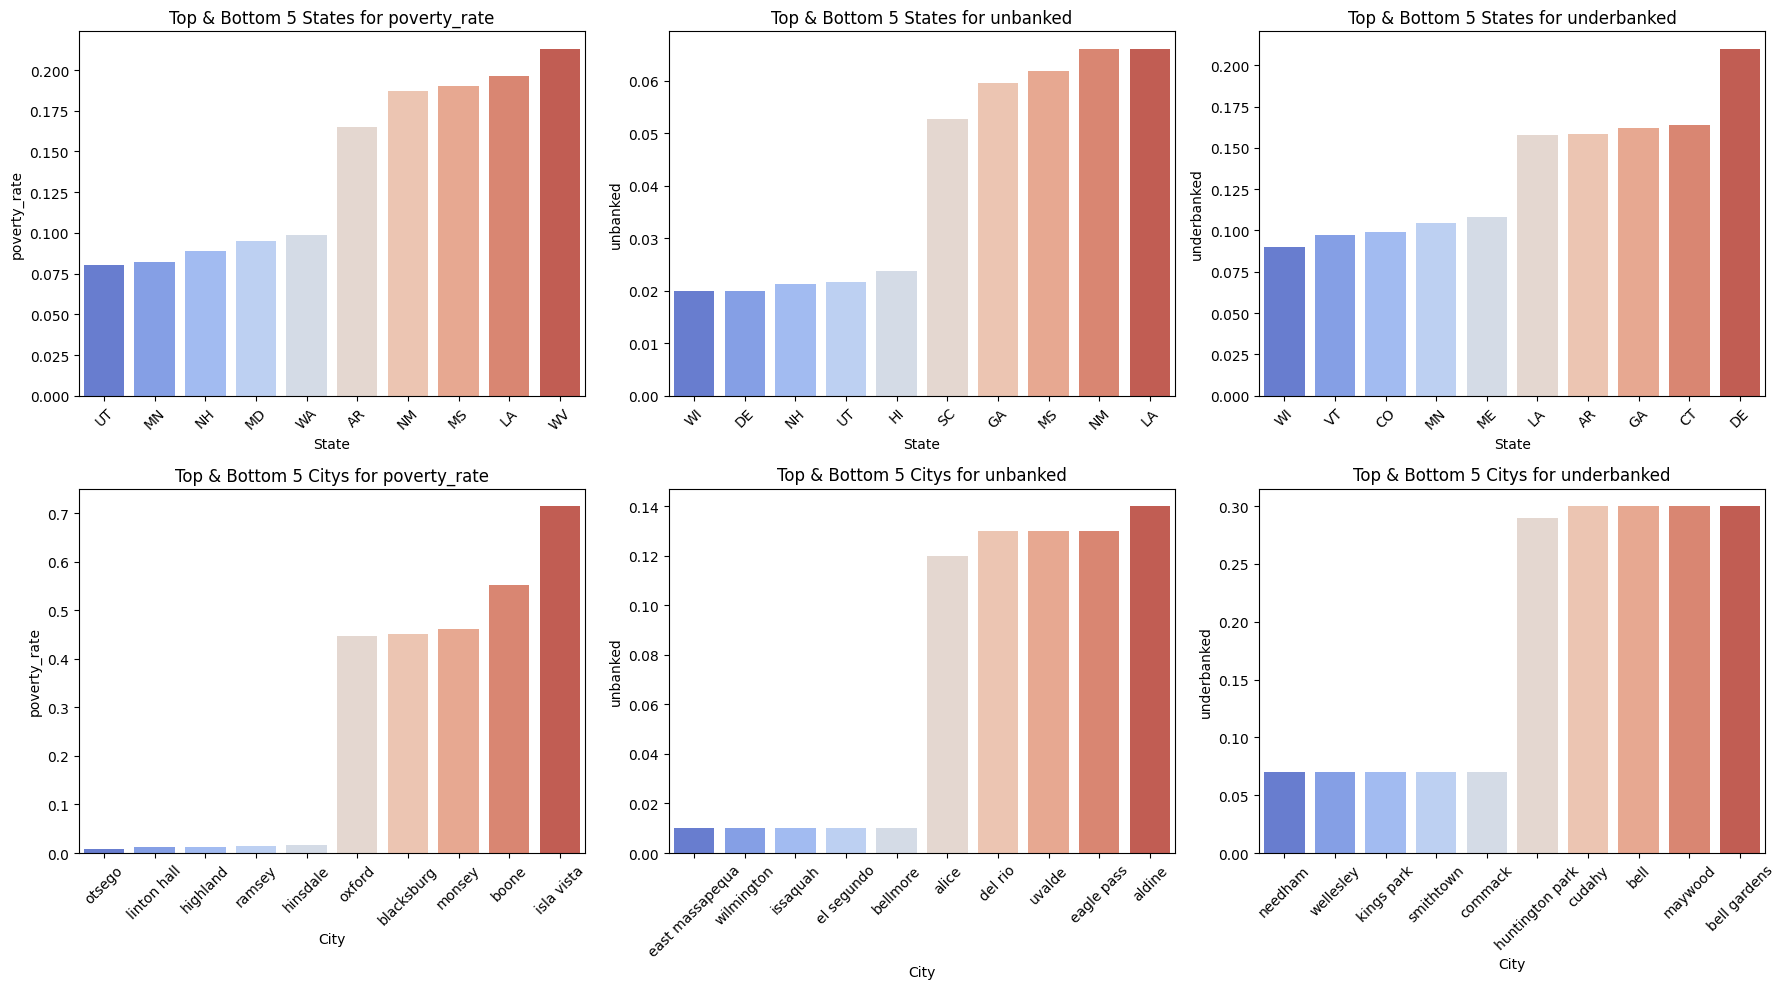

In [863]:
#Look at the top 5 and bottom 5 instances of our variables

group_cols = ["state", "city"]
variables = ["poverty_rate", "unbanked", "underbanked"]

# Create a 2x3 grid for the 6 plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

for i, group_col in enumerate(group_cols):
    for j, var in enumerate(variables):
        grouped = df_merged.groupby(group_col)[var].mean().sort_values()
        top5 = grouped.tail(5)
        bottom5 = grouped.head(5)
        top_bottom = pd.concat([bottom5, top5])
        
        plot_data = pd.DataFrame({group_col: top_bottom.index, var: top_bottom.values})
        
        ax = axes[i, j]
        sns.barplot(x=group_col, y=var, hue=group_col, dodge=False, 
                    palette="coolwarm", data=plot_data, ax=ax)
        ax.set_title(f"Top & Bottom 5 {group_col.capitalize()}s for {var}")
        ax.set_xlabel(group_col.capitalize())
        ax.set_ylabel(var)
        ax.tick_params(axis='x', rotation=45)
        ax.legend([], [], frameon=False)

plt.tight_layout()
plt.show()


In [864]:
# Create our new variable to estimate percent of total sales in cash
df_merged['fully_banked'] = 1.0 - (df_merged['unbanked'] + df_merged['underbanked'])
df_merged['percent_cash'] = .35*df_merged['unbanked'] + .18*df_merged['underbanked'] + .09*df_merged['fully_banked'] 

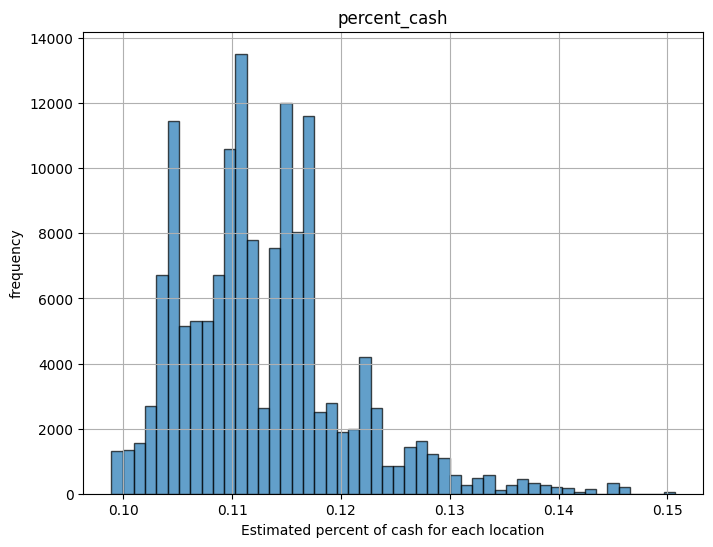

In [865]:
plt.figure(figsize=(8, 6))
plt.hist(df_merged['percent_cash'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Estimated percent of cash for each location')
plt.ylabel('frequency')
plt.title('percent_cash')
plt.grid(True)
plt.show()

In [866]:
# join the new columns back to financial
financial = financial.merge(df_merged.loc[:,['address','name','poverty_rate',
       'unbanked', 'underbanked', 'fully_banked', 'percent_cash']], on = ['address','name'], how = 'left')

The next step is to take our estimated cash percentages to make a multiplier 

In [867]:
# Compute the estimated percentage of sales from cards (remaining after cash & 1% customer financing)
financial["percent_card"] = 1 - (financial["percent_cash"] + 0.01)

# Compute the multiplier
financial["unbanked_multiplier"] = 1 / financial["percent_card"]

In [868]:
financial["unbanked_multiplier"].value_counts()

unbanked_multiplier
1.142596    231751
1.127777    205518
1.128923    199583
1.145869    197531
1.135718    190201
             ...  
1.191469      1543
1.170549      1523
1.148501      1515
1.165773      1464
1.179106      1242
Name: count, Length: 131, dtype: int64

Using square footage of the retailer to adjust cash usage

- After researching the patterns of cash usage, I have learned that it is very tied to the sale price. Smaller transactions are much more likely to be in cash than larger ones.  If we can predict which retailers deal in smaller purchase sizes, we can adjust for a higher multiplier
- The logic here is that smaller stores like convinience stores and fast food will have smaller perchase sizes whereas large grocery, and department stores will deal with large purchase sizes.

- There are of course exceptions like dollar tree stores that are large with cheap items and julery stores that are small with expensive items but overall I believe it is an effective predictor. 

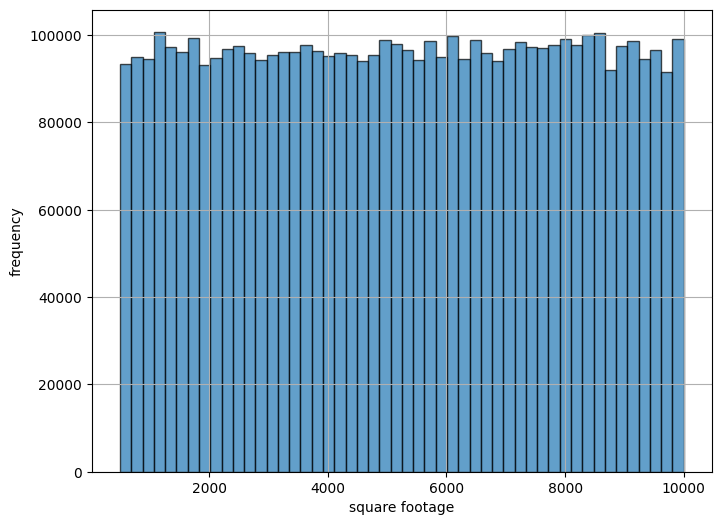

In [869]:
#lets first take a look at the distribution of square footage.  
#It appears that this data is synthetic as I was hoping to see a more clustered distribution.
plt.figure(figsize=(8, 6))
plt.hist(financial['area_sq_ft'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('square footage')
plt.ylabel('frequency')
plt.grid(True)
plt.show()

<Axes: >

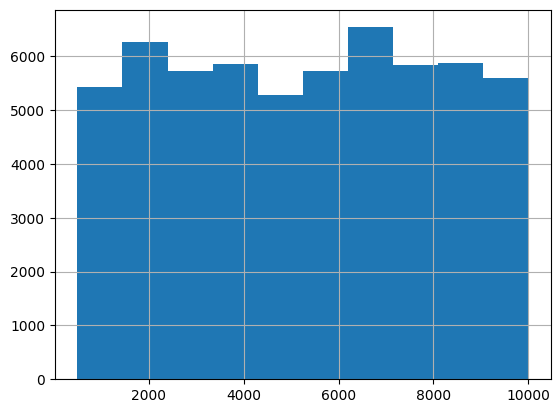

In [870]:
# we further confirm that this is all synthetic by taking a look at a known convience store
# I will proceed as if the data was real and 7eleven was clustered around 2000-3000 square feet like I was expecting
financial.loc[financial['name'] == '7eleven','area_sq_ft'].hist()

After researching typical sizes for retailers, my plan to to bucket the retailers by square footage into the following categories:

=< 3500: convenience store 

3500-5000: fast food 

5000-9000: undefined

9000-40000: grocery store

> 40000: supermarkets and big box retailers

In [871]:
# Make retailer_type variable
def categorize_retailer(size):
    if size <= 3500:
        return "Convenience"
    elif 3500 < size <= 5000:
        return "Fast-Food"
    elif 5000 < size <= 9000:
        return "Undefined"
    elif 9000 < size <= 40000:
        return "Grocery"
    else:
        return "Supermarket/Big-Box" #we wont have any in our dataset

financial["retailer_type"] = financial["area_sq_ft"].apply(categorize_retailer)

https://www.kansascityfed.org/documents/8213/EconomicReviewV106N3Hayashi.pdf  

Our next step is to determine what percent of each retailer type does sales in cash.  There are some conflicting estimates but I will use data I found from the FRB of Kansas City and interpret them to fit my categorizations as follows:

convenience stores: 32% cash
fast food: 30% cash
Grocery stores 15% cash
Supermarkets and Big-Box retailers: 10% cash

 -  These percentages seem high because they are once again in percent of transactions rather than percent of sales. I think this will effect grocery sotres and supermarkets the most because they have a wide range in the size of the sale and likely the largest sales are the ones using card.  Since convenience stores and fast food will have a more consistent size of sale price, their data is more usable.  The following percentages is what I have come up with to estimate the actual percent of sales are in cash.

convenience stores: 30% cash
fast food: 25% cash
undefined: 12%
Grocery stores 9% cash
Supermarkets and Big-Box retailers: 5% cash

In [872]:
# calculate a multiplier based on the percentages we calculated
cash_usage_rates = {
    "Convenience": 0.30,  
    "Fast-Food": 0.25,        
    "Undefined": 0.12,   
    "Grocery": 0.09, 
    "Supermarket/Big-Box": 0.05  
}

# Map the new cash percentages to each retailer type
financial["cash_usage_rate"] = financial["retailer_type"].map(cash_usage_rates)

# Compute multiplier also account fo 1% consumer financing
financial["store_type_multiplier"] = 1/(1-(financial["cash_usage_rate"]+.01))


In [873]:
financial["store_type_multiplier"].value_counts()

store_type_multiplier
1.149425    2045162
1.449275    1517276
1.351351     757946
1.111111     504988
Name: count, dtype: int64

Now that we have both a store type multiplier and an unbanked multiplier we need to find a way to combine them to into a single multiplier.  Simply multiplying the multipliers is an incorrect approach since both have the assumption of added cash. Instead we can take our store multiplier and divide it by 1.149 or 1/(1-.12-.01). The reasoning here is that we are adjusting for the national average of what we would expect in cash. Now large stores will have a store type multiplier below one and small stores above one which will have the correct effect.

In [874]:
financial["store_type_multiplier_adjusted"] = financial["store_type_multiplier"] / (1/.87)
financial["store_type_multiplier_adjusted"].value_counts()

store_type_multiplier_adjusted
1.000000    2045162
1.260870    1517276
1.175676     757946
0.966667     504988
Name: count, dtype: int64

In [875]:
# final step is to multiply our adjusted store type multiplier by our unbanked multiplier and calculate the adjusted revenues
financial["Final_Multiplier"] = financial["store_type_multiplier_adjusted"] * financial["unbanked_multiplier"]
financial['adjusted_revenue'] = financial["Final_Multiplier"] * financial['revenue']

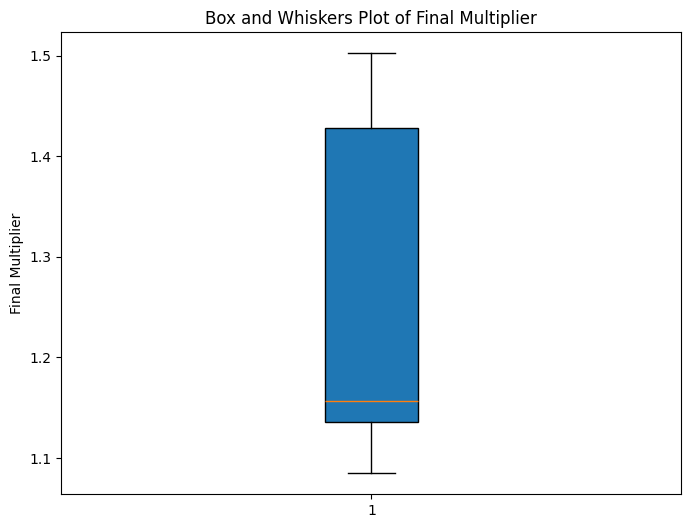

In [876]:
plt.figure(figsize=(8, 6))
plt.boxplot(financial["Final_Multiplier"], vert=True, patch_artist=True)

# Set plot labels and title
plt.title("Box and Whiskers Plot of Final Multiplier")
plt.ylabel("Final Multiplier")

# Show the plot
plt.show()

In [877]:
financial.to_parquet(r"\final_financial_dataset\Financial.parquet")

Interpreting final results:  The final multipliers are distributed as expected with the median around 1.15 with a distinct right skew such that the IQR ranges from just below the median, to upwards of 1.4.  We expect the broad majority of retailers to have a cash revenue that is just below the national average of 12% while certain retailers operating more cash friendly businesses in areas with high unbanked and underbanked populations will skew that number much higher.  

Theoretical Considerations

1.  If we had verified sales data for a subset of locations:
How would you calculate the minimum sample size needed to statistically validate your matching and revenue adjustment approach?

- This question refers to significance testing (or confidence intervals) and how to apply them in this situation. The overall goal is to determine whether the estimated revenues are statistically different from the actual revenue values. Although we cannot "prove" that our estimates are correct, we ideally want to reject the null hypothesis that our average estimates are statistically different from our actual measured values within a specified margin of error.  Assuming the data we obtain is representative of the full population (all locations in our dataset) and is normally distributed, we can use an equivalence test to assess whether the estimated and actual revenues are statistically similar.

-  The number of samples we would need depends on multiple parameters and factors. 
    - The first parameter we choose is an acceptable margin of error.  This is a notional amount saying that as long the averages of our estimates is within $x of the averages of our measured values, we will reject the null hypothesis that the differences between estimate and actual revenues is statistically different.  The larger we choose the less samples we will need
    - The next parameter is the significance level (alpha).  alpha is the probability of rejecting the null hypothesis when it is actually correct.  A common alpha value I often work with is .05. In this case that indicates there is a 5% probability that we claim our estimates are accurate when they are not.  The lower we want to take this value, the more samples we will need
    - Next is the power (1-Beta).  The power is the opposit of significance level in that it is the probability that you fail to reject the null hypothesis when it is actually incorrect. This would be the chance that we fail to claim our predictions were accurate but they actually were. The higher power also increases need for more samples

    The other factors in finding how many samples we need are going to be the mean and standard deviations that we observe from the measured and predicted revenues.  Means that are closer to one another and standard deviations that are larger will require less data.  


2.  If comparing multiple revenue adjustment models What metrics would you use to evaluate superiority?

- I would use a combination of metrics in accordance to what we are needing to prioritize as a business. Accuracy is obviously very important and mean squared error is good for evaluating which model is purely the most accurate.  Another important attribute is robustness of the model.  If a model is potentially overfitting and designed specifically for the data its currently using, but we have plans of using this model in the future on new data, I would prioritize the r-squared value.  Another important factor to look at is if the model results have been tested with a hypothesis test like the one I described above. If one model is able to reject the null hypothesis with a significance level of 0.10 and the other .05, I have good reason to trust the .05 one more.  

How would you ensure comparison validity?"

-To ensure the comparison is valid the data needs to be consistent and robust. Lets say that model A was tested on data that had lots of outliers and unexpected results while model B was tested on extremely smooth data.  Model B might appear to be the better model by accuracy metrics even if Model A is actually the better model.